## Libraries and data import

In [1]:
# Imports
import numpy as np
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes
import numpy
import math
import pandas as pd
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Activation
# from keras.layers import merge
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, GlobalAveragePooling2D
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.optimizers import SGD, Adam
import keras.backend as K
from natsort import natsorted, ns
import keras
import PIL
from keras.regularizers import l2
from glob import glob
from keras.applications import vgg16, xception
from keras.applications import resnet
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, LearningRateScheduler
from matplotlib import pyplot
from sklearn.model_selection import train_test_split

config = tf.compat.v1.ConfigProto()
#config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [2]:
# Data path
data = "dataset/"

# Train and test directories
train_dir = data + "train/"
test_dir = data + "val/"

## Seeds and model parameters

In [3]:
# Fijar las semillas
seed = 2032 # Semilla del numpy
tf.random.set_seed(seed) # Fijar semilla del keras/tensorflow

epochs = 100
batch_size = 32

model_name = 'model_DR.h5'

## Brightness fix through YCrCb color space

In [35]:
def brightness_fix(img):
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_YCrCb = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2YCrCb)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
    cl1 = clahe.apply(img_YCrCb[:,:,0])
    
    img_YCrCb[:,:,0] = cl1         
    img_RGB_2 = cv2.cvtColor(img_YCrCb, cv2.COLOR_YCrCb2RGB)
    
    img_blur = cv2.GaussianBlur(img_RGB_2, (5, 5), 0)
    
    return img_blur

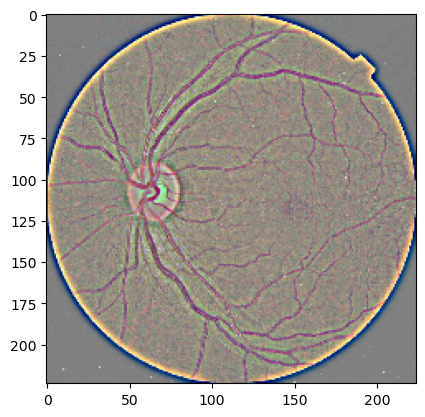

In [36]:
img_p = "no_dr (3).png"

img = cv2.imread(img_p)
pyplot.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
pyplot.show()

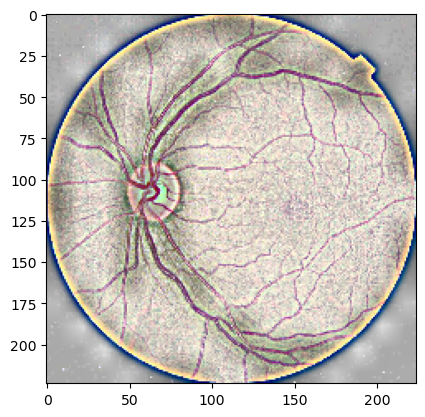

In [37]:
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
img_YCrCb = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2YCrCb)
    
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
cl1 = clahe.apply(img_YCrCb[:,:,0])
    
img_YCrCb[:,:,0] = cl1         
img_RGB_2 = cv2.cvtColor(img_YCrCb, cv2.COLOR_YCrCb2RGB)

pyplot.imshow(img_RGB_2)
pyplot.show()

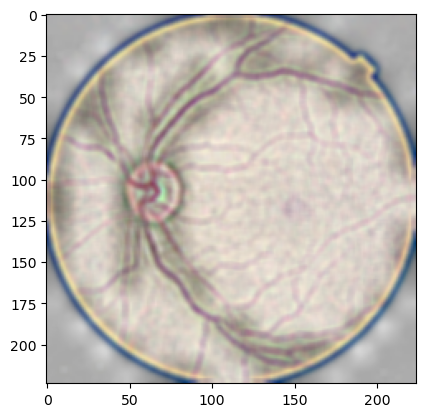

In [38]:
img_blur = cv2.GaussianBlur(img_RGB_2, (5, 5), 2)
pyplot.imshow(img_blur)
pyplot.show()

## Data import and normalization

In [39]:
# Classes
clases = sorted(os.listdir(train_dir))
print(clases)
print(os.path.join(train_dir))

# Train data import
x_train = np.array([brightness_fix(cv2.imread(os.path.join(train_dir, cl, name), cv2.IMREAD_COLOR)) for cl in clases
           for name in os.listdir(os.path.join(train_dir, cl))])
y_lab = np.array([n for n, cl in enumerate(clases)
           for name in os.listdir(os.path.join(train_dir, cl))])

# Train data shuffle
idx = np.random.permutation(len(x_train))
x_train, y_lab = x_train[idx], y_lab[idx]

# One hot encoding
y_train = to_categorical(y_lab, dtype=int)

# Train and validation set
#x_train, x_validation, y_train, y_validation = train_test_split(x_train,y_train,stratify=y_train,test_size=0.2, random_state = 69)

# Test data import
test_files = natsorted(os.listdir(test_dir))
x_test = np.array([brightness_fix(cv2.imread(os.path.join(test_dir, name), cv2.IMREAD_COLOR)) for name in test_files])

['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
dataset/train/


## Data augmentation

In [40]:
# Data generator
datagen = ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization = True,
    validation_split=0.2
    #zoom_range=0.4,
    #horizontal_flip=True,
)

# Validation and test set normalization
datagen.fit(x_train)

#x_validation = (x_validation - datagen.mean)/(datagen.std + 0.000001)
x_test = (x_test - datagen.mean)/(datagen.std + 0.000001)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


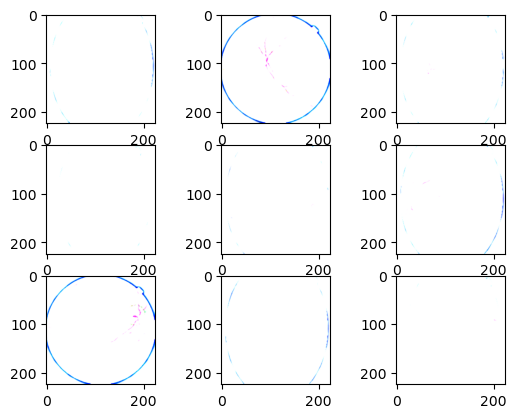

In [41]:
for X_batch, y_batch in datagen.flow(x_train, y_train):
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i])
    pyplot.show()
    break

## Load model

In [42]:
# create the base pre-trained model
base_model = resnet.ResNet50(weights='imagenet',include_top=False, input_shape=(224,224,3))

base_model.summary()

94765736/94765736 [==============================] - 7s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
          

 conv3_block3_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block2_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block1_out[0][0]']       
                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
          

                                )                                                                 
                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

                                                                                                  
 conv5_block1_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_0_bn[0][0]',      
                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
          

## Add transfer learning layers

In [43]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dropout(rate=0.3)(x)
x=Dense(1024, activation='relu')(x)
x=Dropout(rate=0.5)(x)
x=Dense(512,activation='relu')(x) 
preds=Dense(5,activation='softmax')(x) 

model=Model(inputs=base_model.input, outputs=preds)

for i,layer in enumerate(model.layers):
    print(i,layer.name)

0 input_1
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [44]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in model.layers:
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False
        
for layer in model.layers[165:]:
    layer.trainable=True

# compile the model (should be done *after* setting layers to non-trainable)
learning_rate = 0
decay_rate = 0
momentum = 0.9

opt_SGD = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
opt_Adam = Adam(lr=0.000007) 

model.compile(loss='categorical_crossentropy', optimizer=opt_Adam,metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

E:\Anaconda3\envs\tfgpu2\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
E:\Anaconda3\envs\tfgpu2\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 conv3_block4_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block4_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block4_2_relu[0][0]']    
                                                                                                  
 conv3_block4_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block4_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_add (Add)         (None, 28, 28, 512)  0           ['conv3_block3_out[0][0]',       
                                                                  'conv3_block4_3_bn[0][0]']      
          

 conv4_block3_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block3_1_relu[0][0]']    
                                                                                                  
 conv4_block3_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
          

                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block6_1_relu[0][0]']    
                                                                                                  
 conv4_block6_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block6_2_relu[0][0]']    
          

 conv5_block3_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, 7, 7, 512)    2359808     ['conv5_block3_1_relu[0][0]']    
                                                                                                  
 conv5_block3_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block3_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block3_2_bn[0][0]']      
 n)                                                                                               
          

## Run model

In [45]:
early_stopping_callback = EarlyStopping(monitor='val_loss', mode='min', min_delta=0, patience=10, restore_best_weights = True)

def step_decay(epoch):
    if epoch < 15:
        epochs_drop = 30.0
    else:
        epochs_drop = 10.0
    initial_lrate = 0.0001
    drop = 0.5
    
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate

step_decay_callback = LearningRateScheduler(step_decay)

callback_list = [early_stopping_callback]

# fits the model on batches with real-time data augmentation:
#model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
#                   steps_per_epoch=len(x_train) / batch_size, epochs=epochs,
#                   validation_data = (x_validation, y_validation),
#                   validation_steps = len(x_validation) / batch_size,
#                   verbose=1, callbacks=callback_list)

model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size, subset="training"),
                   steps_per_epoch=int(len(x_train)*0.8) / batch_size, epochs=epochs,
                   validation_data = datagen.flow(x_train, y_train, batch_size=batch_size, subset='validation'),
                   validation_steps = int(len(x_train)*0.2) / batch_size,
                   verbose=1, callbacks=callback_list)

model.save(model_name)

Epoch 1/100


C:\Users\maver\AppData\Local\Temp\ipykernel_19160\112572775.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size, subset="training"),


36/36 [==============================] - 16s 223ms/step - loss: 1.8105 - accuracy: 0.2630 - val_loss: 52294160.0000 - val_accuracy: 0.2872
Epoch 2/100
36/36 [==============================] - 6s 172ms/step - loss: 1.6074 - accuracy: 0.3131 - val_loss: 10480.9336 - val_accuracy: 0.2872
Epoch 3/100
36/36 [==============================] - 6s 171ms/step - loss: 1.5419 - accuracy: 0.3382 - val_loss: 27.8268 - val_accuracy: 0.2872
Epoch 4/100
36/36 [==============================] - 6s 171ms/step - loss: 1.4590 - accuracy: 0.3763 - val_loss: 1.8955 - val_accuracy: 0.2837
Epoch 5/100
36/36 [==============================] - 6s 171ms/step - loss: 1.3899 - accuracy: 0.4074 - val_loss: 1.5491 - val_accuracy: 0.3875
Epoch 6/100
36/36 [==============================] - 6s 171ms/step - loss: 1.3708 - accuracy: 0.4247 - val_loss: 1.3872 - val_accuracy: 0.3875
Epoch 7/100
36/36 [==============================] - 6s 171ms/step - loss: 1.3412 - accuracy: 0.4317 - val_loss: 1.2741 - val_accuracy: 0.470

In [46]:

predictions_test = model.predict(x_test, verbose=1)

data = pd.DataFrame()
data['Id'] = test_files
data['Category'] = predictions_test.argmax(axis=-1)


data.to_csv("envio.csv", index=False)

5/5 [==============================] - 2s 127ms/step


In [65]:
import csv
with open('envio.csv') as results:
   csv_reader = csv.reader(results)
   for index, row in enumerate(csv_reader):
      if index == 2:
        img1 = (row[0])
        cat1 = (row[1])
        print(row[0])
        print(row[1])
      if index == 36:
        img2 = (row[0])
        cat2 = (row[1])
        print(row[0])
        print(row[1])
      if index == 68:
        img3 = (row[0])
        cat3 = (row[1])
        print(row[0])
        print(row[1])
      if index == 101:
        img4 = (row[0])
        cat4 = (row[1])
        print(row[0])
        print(row[1])
      if index == 133:
        img5 = (row[0])
        cat5 = (row[1])
        print(row[0])
        print(row[1])
            
results.close()
Score = 0

mild (2).png
0
moderate (5).png
1
no_dr (1).png
2
prol_dr (4).png
3
severe (1).png
4


In [66]:
def res_class(result_flag): 
    global Score
    if result_flag == 0:
        class_result = "Mild"
    elif result_flag == 1:
        class_result = "Moderate"
    elif result_flag == 2:
        class_result = "NO_DR"
    elif result_flag == 3:
        class_result = "Prol_DR"
    elif result_flag == 4:
        class_result = "Severe"
    print(class_result)
    if class_result.lower() in img1 or class_result.lower() in img2 or class_result.lower() in img3 or class_result.lower() in img4 or class_result.lower() in img5:
        Score +=1

Mild


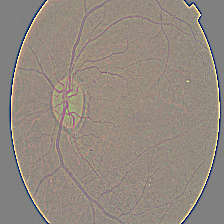

Image file name: mild (2).png


In [67]:
res_class(int(cat1))
from IPython.display import Image, display
display(Image(filename="dataset/val/" +  img1))
print("Image file name: " + img1)

Moderate


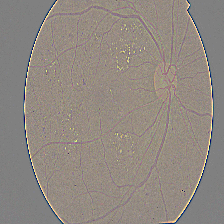

Image file name: moderate (5).png


In [68]:
res_class(int(cat2))
from IPython.display import Image, display
display(Image(filename="dataset/val/" +  img2))
print("Image file name: " + img2)

NO_DR


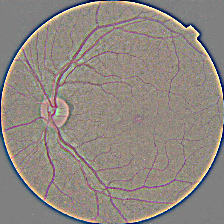

Image file name: no_dr (1).png


In [69]:
res_class(int(cat3))
from IPython.display import Image, display
display(Image(filename="dataset/val/" +  img3))
print("Image file name: " + img3)

Prol_DR


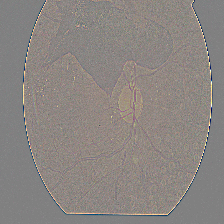

Image file name: prol_dr (4).png


In [70]:
res_class(int(cat4))
from IPython.display import Image, display
display(Image(filename="dataset/val/" +  img4))
print("Image file name: " + img4)

Severe


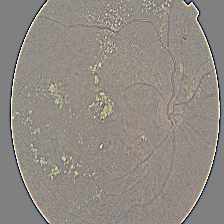

Image file name: severe (1).png


In [71]:
res_class(int(cat5))
from IPython.display import Image, display
display(Image(filename="dataset/val/" +  img5))
print("Image file name: " + img5)

In [72]:
acc = (Score / 5) * 100
print("Classification Accuracy: ")
print(str(acc) + "%")

Classification Accuracy: 
100.0%
